# Modelo de Otimização de Rota "Milk Run"

##### # Importando Módulos

In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
from folium import plugins
import plotly.express as px 

import osmnx as ox 
import networkx as nx

from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2

## Parte I: Importando e Tratando Dados

In [40]:
city = "Sao Paulo"

dados = pd.read_csv('dados/directory.csv')

selecao = dados['Latitude'] < -23.3
dados = dados[selecao]

selecao = dados['Longitude'] < -46.5
dados = dados[selecao]

dados = dados[dados["City"]==city][
        ["City","Street Address","Latitude","Longitude"]
      ].reset_index(drop=True)
dados = dados.reset_index().rename(
      columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dados))
dados.head()

tot: 46


id       City                                     Street Address      y  \
0   0  Sao Paulo                            Rua Maestro Cardim, 769 -23.57   
1   1  Sao Paulo  Av. Washington Luis, s/n, Sagua Central, Vila ... -23.63   
2   2  Sao Paulo  Av. Paulista, 2.064, Piso Augusta Lojas A-1,A-... -23.56   
3   3  Sao Paulo                             Avenida Paulista, 1203 -23.56   
4   4  Sao Paulo                                     Av. Pavao, 667 -23.61   

       x  
0 -46.64  
1 -46.66  
2 -46.66  
3 -46.65  
4 -46.67

In [41]:
dados.shape

(46, 5)

In [42]:
i = 0
dados["base"] = dados["id"].apply(lambda x: 1 if x==i else 0)
inicio = dados[dados["base"]==1][["y","x"]].values[0]

print("início =", inicio)
dados.head(3)

início = [-23.57 -46.64]


id       City                                     Street Address      y  \
0   0  Sao Paulo                            Rua Maestro Cardim, 769 -23.57   
1   1  Sao Paulo  Av. Washington Luis, s/n, Sagua Central, Vila ... -23.63   
2   2  Sao Paulo  Av. Paulista, 2.064, Piso Augusta Lojas A-1,A-... -23.56   

       x  base  
0 -46.64     1  
1 -46.66     0  
2 -46.66     0

## Parte II: Plotando Dados

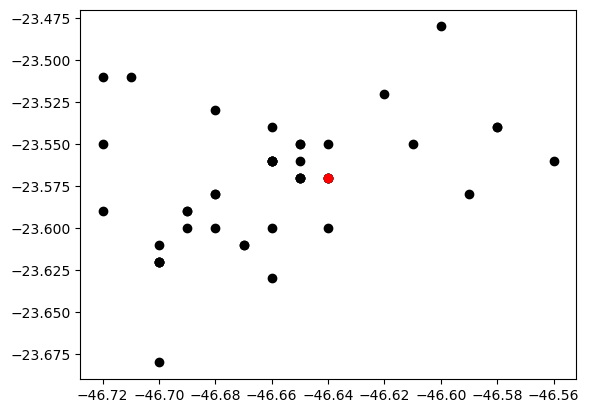

In [43]:
plt.scatter(y=dados["y"], x=dados["x"], color="black")
plt.scatter(y=inicio[0], x=inicio[1], color="red")
plt.show()

In [44]:
def plotar_mapa(dados, y, x, inicio, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dados.copy()

    if color is not None:
        lst_elements = sorted(list(dados[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    mapa = folium.Map(location=inicio, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(mapa), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(mapa), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(mapa), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(mapa), axis=1)
    
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(mapa)
    folium.LayerControl(position='bottomright').add_to(mapa)
    
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        mapa.get_root().html.add_child(folium.Element(legend_html))
    
    if marker is not None:
        lst_elements = sorted(list(dados[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
   
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(mapa), axis=1) 
       
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(mapa), axis=1)
    
    
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(mapa)
    
    return mapa

In [45]:
mapa = plotar_mapa(dados, y="y", x="x", inicio=inicio, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black", "red"])
mapa

In [46]:
for i in range(len(dados)):
    points = [inicio, dados[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(mapa)
mapa

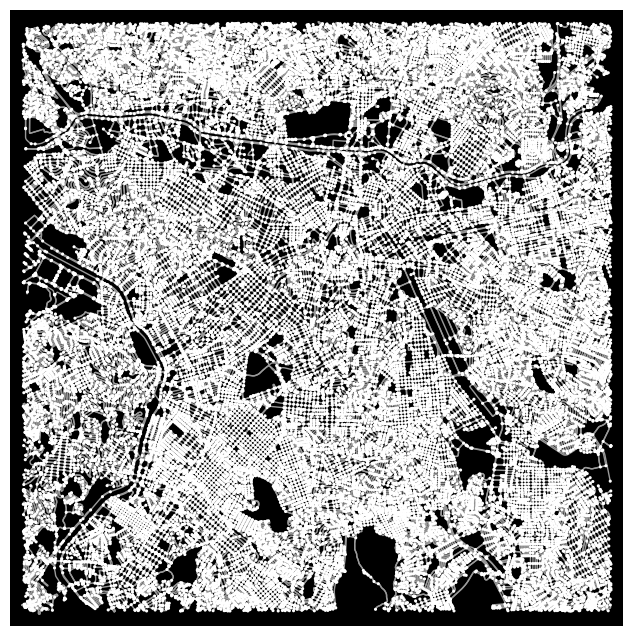

In [47]:
G = ox.graph_from_point(inicio, dist=10000, network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [48]:
[i for i in G.nodes()][:10]

[573641,
 573643,
 573644,
 577239,
 582142,
 582438,
 582442,
 582506,
 587858,
 587859]

In [49]:
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 48336


osmid          y          x  street_count highway  ref  \
0  573641 -23.562991 -46.703965             3     NaN  NaN   
1  573643 -23.567465 -46.702229             3     NaN  NaN   
2  573644 -23.572962 -46.699235             3     NaN  NaN   

                      geometry  
0  POINT (-46.70397 -23.56299)  
1  POINT (-46.70223 -23.56746)  
2  POINT (-46.69923 -23.57296)

In [50]:
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 110209


u           v  key                              osmid  oneway   lanes  \
0  573641  4345300990    0                           26661283    True       2   
1  573641   465879071    0                          493634438    True       3   
2  573643   292424978    0  [692286399, 493634438, 936811959]    True  [4, 3]   

                                        name   highway reversed   length  ...  \
0  Avenida Professor Frederico Herman Júnior  tertiary    False   33.384  ...   
1               Avenida Doutora Ruth Cardoso     trunk    False   25.403  ...   
2               Avenida Doutora Ruth Cardoso     trunk    False  274.205  ...   

   maxspeed                                           geometry  ref bridge  \
0       NaN  LINESTRING (-46.70397 -23.56299, -46.70373 -23...  NaN    NaN   
1        60  LINESTRING (-46.70397 -23.56299, -46.70408 -23...  NaN    NaN   
2        60  LINESTRING (-46.70223 -23.56746, -46.70228 -23...  NaN    NaN   

  junction width tunnel access service est_width  
0      NaN   NaN    NaN    NaN     NaN       NaN  
1      NaN   NaN    NaN    NaN     NaN       NaN  
2      NaN   NaN    NaN    NaN     NaN       NaN  

[3 rows x 22 columns]

## Parte IV: Calculando Rotas usando o Algoritmo de Dijkstra com Base no Tempo

In [51]:
final = dados[dados["id"]==30][["y","x"]].values[0]
print("localização: de", inicio, "--> para", final)

localização: de [-23.57 -46.64] --> para [-23.62 -46.7 ]


In [52]:
node_inicio = ox.distance.nearest_nodes(G, inicio[1], inicio[0])
node_fim = ox.distance.nearest_nodes(G, final[1], final[0])
print("nodes: de", node_inicio, "--> para", node_fim)

nodes: de 778098426 --> para 4246898827


67 nodes --> [778098426, 1833396358, 7991923056, 7991923055, 5539305452, 2619793475, 25929616, 5711623858, 5102154381, 6245550726, 142835392, 3278570098, 8062402669, 303788740, 303788766, 8062402671, 8073365127, 1389167417, 40258180, 2554827901, 301666121, 300058904, 1452863177, 27868184, 51255414, 3316840703, 1550389893, 51255350, 1389167451, 1389167458, 1389167464, 302806150, 27496524, 1389167477, 315145718, 1645973872, 8062160846, 1445876315, 265575801, 1445876344, 1634767180, 1953903594, 7167696510, 1953903589, 1962762384, 2843304439, 1962762387, 3881929681, 7167696508, 6018574851, 303890490, 25614437, 25629335, 25629382, 8710455016, 25629402, 1107272537, 25629454, 25629455, 1106899589, 25629490, 25641377, 25641374, 7285433192, 4743959839, 4743959835, 4246898827]


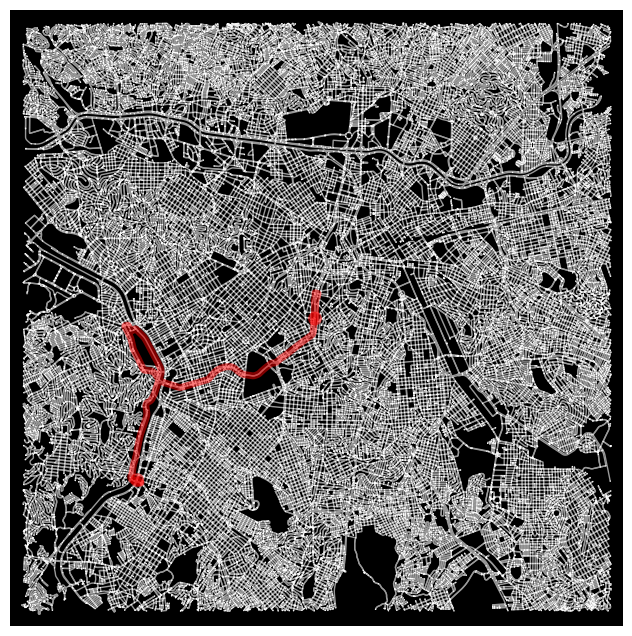

In [53]:
caminho_distancia = nx.shortest_path(G, source=node_inicio, target=node_fim, method='dijkstra', weight='lenght')
print(len(caminho_distancia), "nodes -->", caminho_distancia)

fig, ax = ox.plot_graph_route(G, caminho_distancia, route_color="red", route_linewidth=5,
                              node_size=1, bgcolor='black', node_color="white",
                              figsize=(16,8))

143 nodes --> [778098426, 1833396358, 7991923056, 7991923055, 5539305452, 5539305457, 172017421, 1833396367, 172021002, 9098873805, 2578181728, 1833396362, 457593263, 172020870, 8765779194, 457593200, 863898797, 142808171, 457593059, 10886806485, 142808169, 1953466359, 1953466361, 2397319383, 142799353, 184038866, 142808168, 303857363, 303857124, 1393378086, 1393378087, 303855013, 142808165, 142808164, 303858540, 142808163, 303858897, 303856858, 303859169, 4167937333, 3315170402, 3315170401, 3315170400, 3315170399, 3315170398, 3315170396, 3315170392, 1942703850, 1942703818, 303788683, 303788550, 303788470, 303788688, 1942703864, 303788554, 142811320, 142811321, 1942703721, 4484877102, 142811323, 142811324, 1389167277, 1389167279, 40258826, 1389167323, 8751100009, 1389167342, 40258221, 1389167366, 8061463164, 1389167377, 300058932, 4345247821, 1389167417, 40258180, 2554827901, 301666121, 300058904, 1452863177, 27868184, 51255414, 3316840703, 1550389893, 51255350, 1389167451, 1389167458,

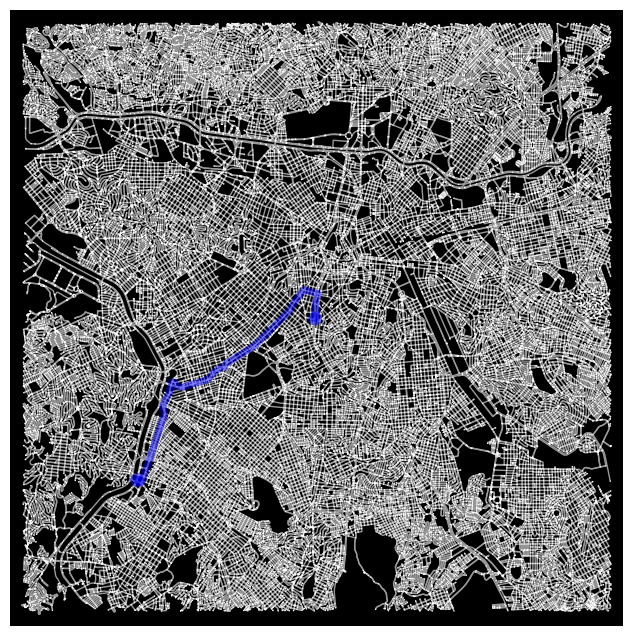

In [54]:
caminho_tempo = nx.shortest_path(G, source=node_inicio, target=node_fim, method='dijkstra', weight='travel_time')
print(len(caminho_tempo), "nodes -->", caminho_tempo)

fig, ax = ox.plot_graph_route(G, caminho_tempo, route_color="blue", route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

Rota vermelha: 17.38 km | 18.18 min
Rota azul: 11.08 km | 13.36 min


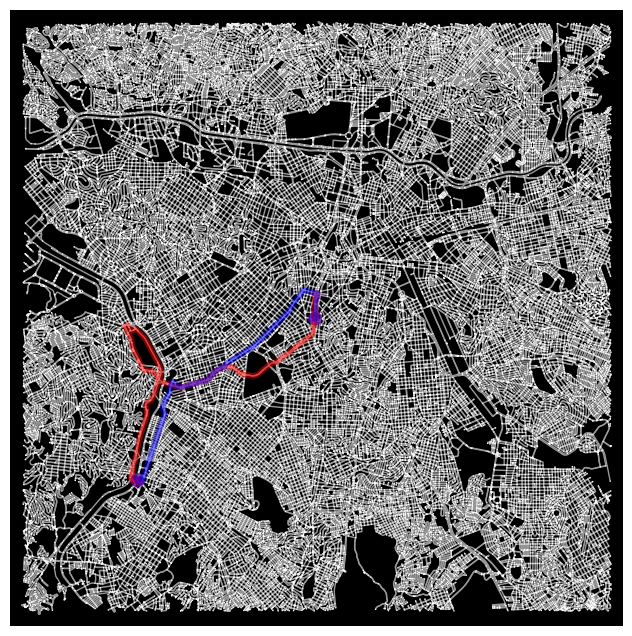

In [55]:
print('Rota vermelha:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,caminho_distancia,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,caminho_distancia,'travel_time'))/60, 2), 
      'min')

print('Rota azul:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,caminho_tempo,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,caminho_tempo,'travel_time'))/60, 2), 
      'min')

fig, ax = ox.plot_graph_routes(G, routes=[caminho_distancia, caminho_tempo], 
                              route_colors=["red","blue"], route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [56]:
mapa = plotar_mapa(dados, y="y", x="x", inicio=inicio, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=caminho_distancia, route_map=mapa, color="red", weight=1)
ox.plot_route_folium(G, route=caminho_tempo, route_map=mapa, color="blue", weight=1)
mapa

In [57]:
def df_animacao_caminho_unico(G, caminho):
    lst_inicio, lst_final = [],[]
    inicio_x, inicio_y = [],[]
    final_x, final_y = [],[]
    lst_distancia, lst_tempo = [],[]

    for a,b in zip(caminho[:-1], caminho[1:]):
        lst_inicio.append(a)
        lst_final.append(b)
        lst_distancia.append(round(G.edges[(a,b,0)]['length']))
        lst_tempo.append(round(G.edges[(a,b,0)]['travel_time']))
        inicio_x.append(G.nodes[a]['x'])
        inicio_y.append(G.nodes[a]['y'])
        final_x.append(G.nodes[b]['x'])
        final_y.append(G.nodes[b]['y'])

    df = pd.DataFrame(list(zip(lst_inicio, lst_final, inicio_x, inicio_y, final_x, final_y, lst_distancia, lst_tempo)), 
                       columns=["início","final","inicio_x","inicio_y","final_x","final_y","length","travel_time"]
                     ).reset_index().rename(columns={"index":"id"})
    return df
print("nodes: de", node_inicio, "--> para", node_fim)

df = df_animacao_caminho_unico(G, caminho_tempo)
df.head()

nodes: de 778098426 --> para 4246898827


id      início       final   inicio_x   inicio_y    final_x    final_y  \
0   0   778098426  1833396358 -46.640716 -23.570443 -46.640331 -23.564347   
1   1  1833396358  7991923056 -46.640331 -23.564347 -46.639737 -23.562861   
2   2  7991923056  7991923055 -46.639737 -23.562861 -46.639721 -23.562767   
3   3  7991923055  5539305452 -46.639721 -23.562767 -46.640719 -23.562585   
4   4  5539305452  5539305457 -46.640719 -23.562585 -46.640845 -23.562556   

   length  travel_time  
0     681           41  
1     178           14  
2      11            1  
3     104            9  
4      13            1

In [58]:
def plotar_animacao(df, node_inicio, node_fim):
    
    df_inicio = df[df["início"] == node_inicio]
    df_final = df[df["final"] == node_fim]
    
    
    fig = px.scatter_mapbox(data_frame=df, lon="inicio_x", lat="inicio_y", zoom=15, width=1000, height=800, 
      
                            animation_frame="id", mapbox_style="carto-positron")
    fig.data[0].marker = {"size":12}
    
    fig.add_trace(px.scatter_mapbox(data_frame=df_inicio, lon="inicio_x", lat="inicio_y").data[0])
    fig.data[1].marker = {"size":15, "color":"red"}
    
    fig.add_trace(px.scatter_mapbox(data_frame=df_final, lon="inicio_x", lat="inicio_y").data[0])
    fig.data[2].marker = {"size":15, "color":"green"}
    
    fig.add_trace(px.line_mapbox(data_frame=df, lon="inicio_x", lat="inicio_y").data[0])
    return fig

In [59]:
plotar_animacao(df, node_inicio, node_fim)

In [60]:
def df_animacao_caminhos_multiplos(G, lst_caminhos, parallel=True):
    df = pd.DataFrame()
    for caminho in lst_caminhos:
        lst_inicio, lst_final = [],[]
        inicio_x, inicio_y = [],[]
        final_x, final_y = [],[]
        lst_distancia, lst_tempo = [],[]

        for a,b in zip(caminho[:-1], caminho[1:]):
            lst_inicio.append(a)
            lst_final.append(b)
            lst_distancia.append(round(G.edges[(a,b,0)]['length']))
            lst_tempo.append(round(G.edges[(a,b,0)]['travel_time']))
            inicio_x.append(G.nodes[a]['x'])
            inicio_y.append(G.nodes[a]['y'])
            final_x.append(G.nodes[b]['x'])
            final_y.append(G.nodes[b]['y'])

        tmp = pd.DataFrame(list(zip(lst_inicio, lst_final, inicio_x, inicio_y, final_x, final_y, lst_distancia, lst_tempo)), 
                           columns=["início","final","inicio_x","inicio_y","final_x","final_y","length","travel_time"]
                          )
        df = pd.concat([df,tmp], ignore_index=(not parallel))

    df = df.reset_index().rename(columns={"index":"id"})
    return df

In [61]:
primeiro_node, ultimo_node = node_inicio, node_fim
lst_caminhos = [caminho_tempo, caminho_distancia]
print(len(lst_caminhos), "caminhos,", sum(len(i) for i in lst_caminhos), "nodes:", primeiro_node, "...", ultimo_node)

df = df_animacao_caminhos_multiplos(G, lst_caminhos, parallel=True)
df.tail()

2 caminhos, 210 nodes: 778098426 ... 4246898827


id      início       final   inicio_x   inicio_y    final_x    final_y  \
203  61    25641377    25641374 -46.701817 -23.619779 -46.701120 -23.620143   
204  62    25641374  7285433192 -46.701120 -23.620143 -46.698985 -23.620780   
205  63  7285433192  4743959839 -46.698985 -23.620780 -46.698940 -23.620795   
206  64  4743959839  4743959835 -46.698940 -23.620795 -46.698835 -23.620666   
207  65  4743959835  4246898827 -46.698835 -23.620666 -46.700067 -23.619876   

     length  travel_time  
203      83            6  
204     229           16  
205       5            0  
206      28            2  
207     163           12

In [62]:
plotar_animacao(df, primeiro_node, ultimo_node)

In [63]:
dados["node"] = dados[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G,x[1],x[0]), axis=1)
dados = dados.drop_duplicates("node", keep='first')
dados.head()

id       City                                     Street Address      y  \
0   0  Sao Paulo                            Rua Maestro Cardim, 769 -23.57   
1   1  Sao Paulo  Av. Washington Luis, s/n, Sagua Central, Vila ... -23.63   
2   2  Sao Paulo  Av. Paulista, 2.064, Piso Augusta Lojas A-1,A-... -23.56   
3   3  Sao Paulo                             Avenida Paulista, 1203 -23.56   
4   4  Sao Paulo                                     Av. Pavao, 667 -23.61   

       x  base        node  
0 -46.64     1   778098426  
1 -46.66     0  6361292097  
2 -46.66     0    60624596  
3 -46.65     0   457566731  
4 -46.67     0  5080376201

In [64]:
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a,b) for b in dados["node"].tolist()] for a in dados["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=dados["node"].values, index=dados["node"].values)
distance_matrix.head()

778098426   6361292097  60624596    457566731   5080376201  \
778098426          0.0       608.1       293.9       201.5       520.2   
6361292097       507.9         0.0       701.2       665.3       358.8   
60624596         241.3       674.3         0.0       150.0       554.9   
457566731        274.3       707.3       189.7         0.0       599.5   
5080376201       399.5       239.3       568.3       547.5         0.0   

            4279348730  2615693298  1691276598  301650873   25778062    ...  \
778098426        397.5       599.8         NaN       640.0       448.0  ...   
6361292097       425.6      1107.7         NaN       510.9       955.9  ...   
60624596         436.4       736.4         NaN       519.1       532.3  ...   
457566731        469.4       644.5         NaN       621.2       441.5  ...   
5080376201       324.5       999.3         NaN       254.2       847.5  ...   

            4663903407  5994312468  304693470   4246898827  5539086397  \
778098426        976.8       799.3       410.0       801.5       234.5   
6361292097      1236.5      1307.2       321.6       571.5       742.4   
60624596         830.0       935.9       425.3       637.4       228.6   
457566731        914.6       844.0       469.9       751.2       137.8   
5080376201       979.8      1198.8       141.3       329.6       634.0   

            1360432237  8062328093  3894483856  2395110368  5087298463  
778098426       1045.4       543.7       881.7       654.5       593.2  
6361292097       706.5       562.9       916.7      1000.2       431.7  
60624596        1021.1       410.8       644.1       791.1       480.8  
457566731       1091.2       524.6       777.5       699.2       550.9  
5080376201       576.4       306.2       660.0       903.1       175.0  

[5 rows x 29 columns]

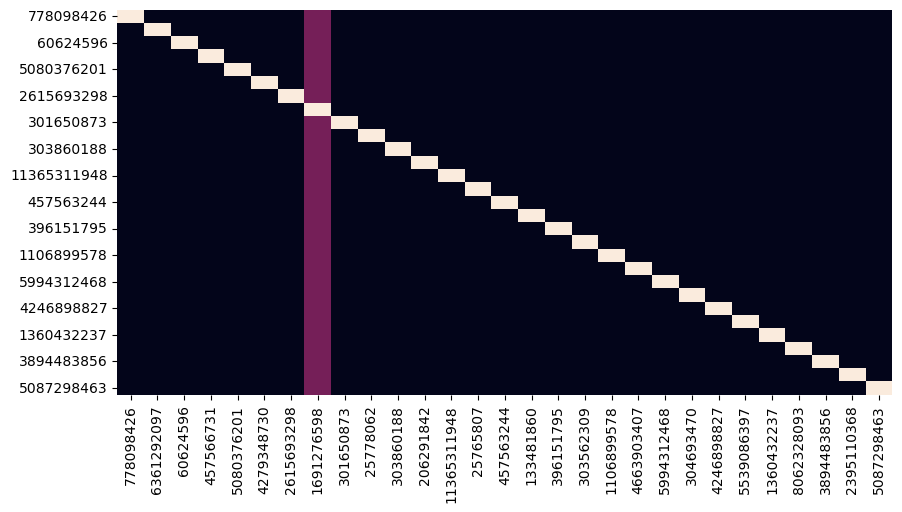

In [65]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [66]:
distance_matrix = distance_matrix.T.fillna(distance_matrix.mean(axis=1)).T

distance_matrix.head()

778098426   6361292097  60624596    457566731   5080376201  \
778098426          0.0       608.1       293.9       201.5       520.2   
6361292097       507.9         0.0       701.2       665.3       358.8   
60624596         241.3       674.3         0.0       150.0       554.9   
457566731        274.3       707.3       189.7         0.0       599.5   
5080376201       399.5       239.3       568.3       547.5         0.0   

            4279348730  2615693298  1691276598  301650873   25778062    ...  \
778098426        397.5       599.8  558.503571       640.0       448.0  ...   
6361292097       425.6      1107.7  740.714286       510.9       955.9  ...   
60624596         436.4       736.4  505.135714       519.1       532.3  ...   
457566731        469.4       644.5  535.739286       621.2       441.5  ...   
5080376201       324.5       999.3  577.564286       254.2       847.5  ...   

            4663903407  5994312468  304693470   4246898827  5539086397  \
778098426        976.8       799.3       410.0       801.5       234.5   
6361292097      1236.5      1307.2       321.6       571.5       742.4   
60624596         830.0       935.9       425.3       637.4       228.6   
457566731        914.6       844.0       469.9       751.2       137.8   
5080376201       979.8      1198.8       141.3       329.6       634.0   

            1360432237  8062328093  3894483856  2395110368  5087298463  
778098426       1045.4       543.7       881.7       654.5       593.2  
6361292097       706.5       562.9       916.7      1000.2       431.7  
60624596        1021.1       410.8       644.1       791.1       480.8  
457566731       1091.2       524.6       777.5       699.2       550.9  
5080376201       576.4       306.2       660.0       903.1       175.0  

[5 rows x 29 columns]

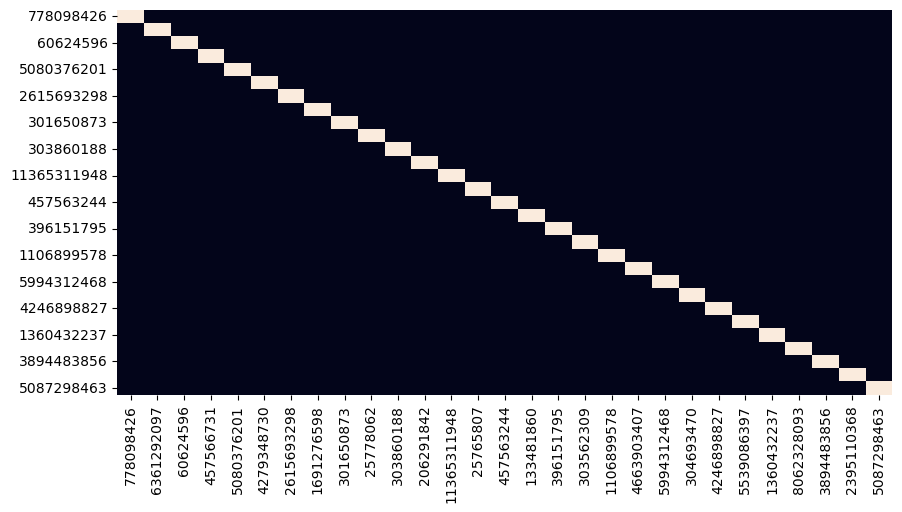

In [67]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [68]:
drivers = 1

In [69]:
lst_nodes = dados["node"].tolist()
print("início:", node_inicio, "| tot localizações para visistar:", len(lst_nodes)-1, "| motorista:", drivers)

início: 778098426 | tot localizações para visistar: 28 | motorista: 1


In [70]:
len(distance_matrix.iloc[1])

29

In [71]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(node_inicio))
model = pywrapcp.RoutingModel(manager)

def encontrar_distancia(from_index, to_index):
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(encontrar_distancia)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

index = model.Start(0)
print('Rota por motorista:')
route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append( manager.IndexToNode(index) ) 
    previous_index = index
    index = solution.Value( model.NextVar(index) )
    try:
        route_distance += encontrar_distancia(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Distância total: {round(route_distance/1000,2)} km')
print(f'Nodes visitados: {len(route_idx)}')

Rota por motorista:
[0, 23, 3, 10, 2, 14, 16, 11, 9, 6, 15, 27, 20, 5, 21, 4, 28, 8, 25, 17, 18, 22, 1, 24, 26, 12, 19, 13, 7]
Distância total: 9.68 km
Nodes visitados: 29


In [72]:
print("Rota por motorista (nodes):")
lst_rota = [lst_nodes[i] for i in route_idx]
print(lst_rota)

Rota por motorista (nodes):
[778098426, 5539086397, 457566731, 303860188, 60624596, 457563244, 396151795, 206291842, 25778062, 2615693298, 133481860, 2395110368, 5994312468, 4279348730, 304693470, 5080376201, 5087298463, 301650873, 8062328093, 303562309, 1106899578, 4246898827, 6361292097, 1360432237, 3894483856, 11365311948, 4663903407, 25765807, 1691276598]


In [73]:
def localizar_caminho_nodes(lst_rota):
    lst_caminhos = []
    for i in range(len(lst_rota)):
        
        try:
            a,b = lst_rota[i], lst_rota[i+1]
        except:
            break
    
        try:
            caminho = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(caminho) > 1:
                lst_caminhos.append(caminho)
        except:
            continue
    return lst_caminhos

In [74]:
lst_caminhos = localizar_caminho_nodes(lst_rota)
len(lst_caminhos)

27

## Parte V: Plotando Rota Otimizada

In [75]:
mapa = plotar_mapa(dados, y="y", x="x", inicio=inicio, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

for caminho in lst_caminhos:
    ox.plot_route_folium(G, route=caminho, route_map=mapa, color="blue", weight=1)
mapa

In [76]:
primeiro_node, ultimo_node = lst_caminhos[0][0], lst_caminhos[-1][-1]
print(len(lst_caminhos), "caminhos,", sum(len(i) for i in lst_caminhos), "nodes:", primeiro_node, "...", ultimo_node)

df = df_animacao_caminhos_multiplos(G, lst_caminhos, parallel=False)
plotar_animacao(df, primeiro_node, ultimo_node)

27 caminhos, 1116 nodes: 778098426 ... 25765807
